# Mauna Loa CO2

In this Notebook (as a lot of other ones) we'll consider modelling the Mauna Loa CO2 dataset using structural timeseries in numpyro. As always, we begin importing the data

In [1]:
import pandas as pd
from sklearn.datasets import fetch_openml

datas = fetch_openml(data_id=41187, as_frame=True).frame
datas.head()

,year,month,day,weight,flag,station,co2
0,1958,3,29,4,0,MLO,316.1
1,1958,4,5,6,0,MLO,317.3
2,1958,4,12,4,0,MLO,317.6
3,1958,4,19,6,0,MLO,317.5
4,1958,4,26,2,0,MLO,316.4


Let's construct a proper date time value and set as index

In [2]:
datas.index = datas.apply(lambda u: pd.Timestamp(year=u["year"], month=u["month"], day=u["day"]), axis=1)

datas.head()

,year,month,day,weight,flag,station,co2
1958-03-29,1958,3,29,4,0,MLO,316.1
1958-04-05,1958,4,5,6,0,MLO,317.3
1958-04-12,1958,4,12,4,0,MLO,317.6
1958-04-19,1958,4,19,6,0,MLO,317.5
1958-04-26,1958,4,26,2,0,MLO,316.4


Let's only select the CO2 column and resample to monthly

Text(0.5, 1.0, 'CO2 at Mauna Loa')

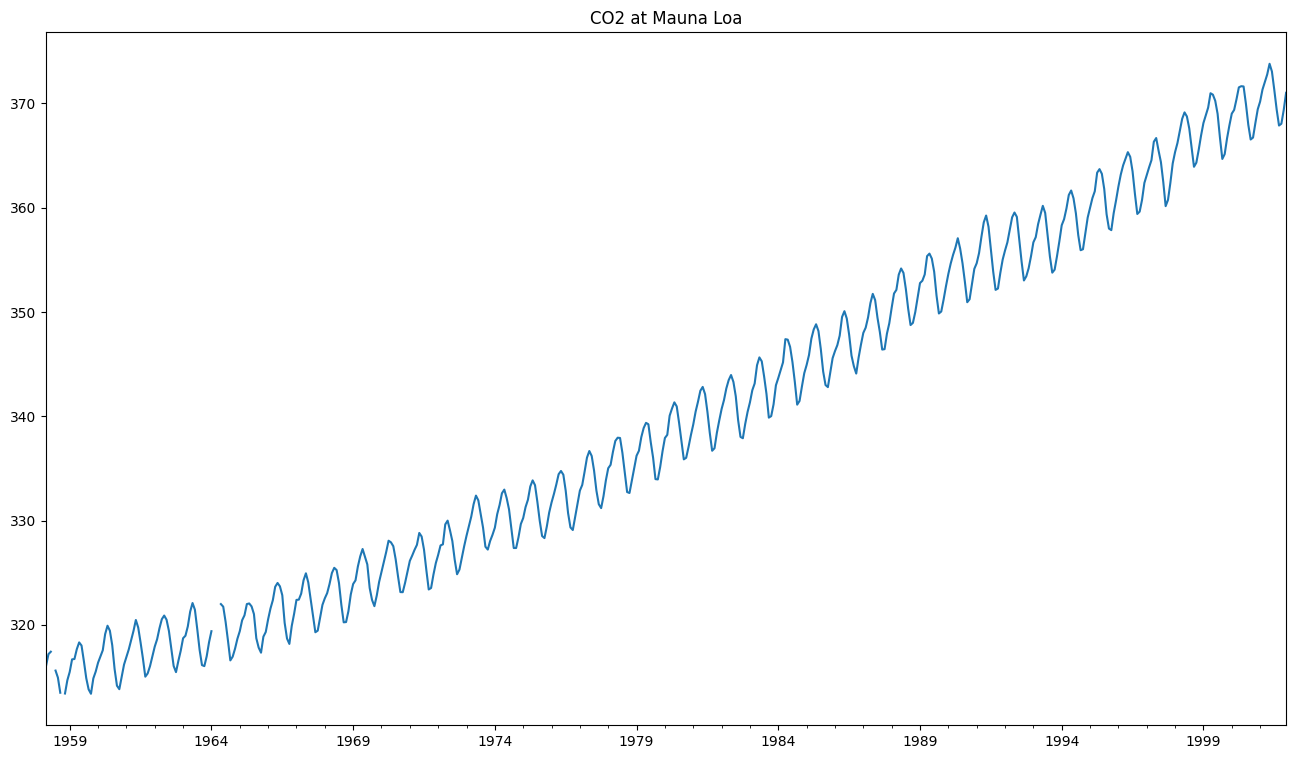

In [3]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (16, 9)

co2 = datas["co2"].resample("ME").mean()

fig, ax = plt.subplots()
co2.plot(ax=ax)

ax.set_title("CO2 at Mauna Loa")

We clearly see that there is both a trend and seasonality component in the data. The model seems to be additive as it doesn't grow/shrink with time. The seasonality component seems to be constant. Let's set up our model

In [27]:
from numpyro.distributions import HalfNormal, Normal, HalfCauchy, ZeroSumNormal
import numpyro
from numpyro_sts import periodic, RandomWalk
import numpy as np


numpyro.set_host_device_count(4)
numpyro.set_platform("cpu")


def model(n: int, y: np.ndarray = None, mask: bool = True, num_seasons: int = 12, future: int = 0):
    # level component
    with numpyro.handlers.scope(prefix="level"):
        std = numpyro.sample("std", HalfNormal(scale=100.0))
        drift = numpyro.sample("drift", HalfNormal())

        x_0_loc = numpyro.sample("x_0_loc", Normal(scale=1000.0))
        x_0 = x_0_loc + numpyro.sample("x_0", Normal())

        level_model = RandomWalk(n, std, x_0, drift=drift)
        level = numpyro.sample("x", level_model)

        if future > 0:
            future_level = numpyro.sample("x_future", level_model.predict(future, level[-1]))

    # seasonality
    with numpyro.handlers.scope(prefix="seasonality"):
        x_0 = numpyro.sample("x_0", ZeroSumNormal(scale=10.0, event_shape=(num_seasons,)))[:-1]

        seasonality_model = periodic.TimeSeasonal(n, num_seasons, 0.0, x_0)
        seasonality = numpyro.deterministic("x", seasonality_model.deterministic())

        if future > 0:
            future_seasonality = numpyro.deterministic(
                "x_future", seasonality_model.predict(future, seasonality[-1]).deterministic()
            )

    # observable
    std = numpyro.sample("std", HalfCauchy())
    loc = level[..., 0] + seasonality[..., 0]

    with numpyro.handlers.mask(mask=mask):
        y_ = numpyro.sample("y", Normal(loc, std), obs=y)

    if future > 0:
        loc_future = future_level[..., 0] + future_seasonality[..., 0]
        y_future = numpyro.sample("y_future", Normal(loc_future, std))

    return

Since we have a fully probabilistic model, let's sample from the model and see it's outputs

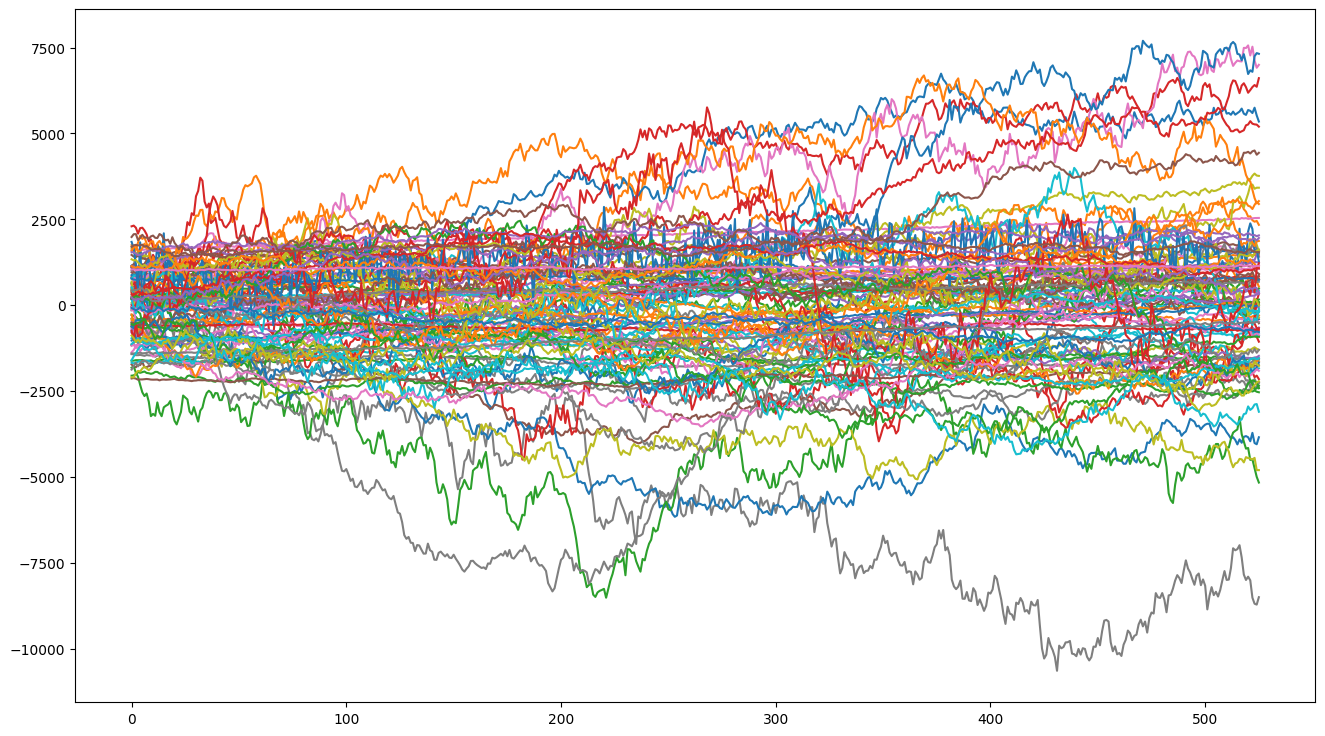

In [28]:
from numpyro.infer import Predictive
import jax.random as jrnd

predictive = Predictive(model, num_samples=100)
key = jrnd.PRNGKey(0)

samples = predictive(key, n=co2.shape[0])

fig, ax = plt.subplots()
ax.plot(samples["y"].swapaxes(0, -1))

Alright, let's perform some inference

In [29]:
from sklearn.model_selection import train_test_split
from numpyro.infer import NUTS, MCMC

kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=5_000, num_samples=1_000, num_chains=4, chain_method="sequential")

train, test = train_test_split(co2.values, shuffle=False)
mcmc.run(key, n=train.shape[0], y=train, mask=np.isfinite(train))

sample: 100%|██████████| 6000/6000 [00:22<00:00, 261.35it/s, 31 steps of size 1.42e-01. acc. prob=0.90]


Let's look at the summary

In [30]:
mcmc.print_summary()


                         mean       std    median      5.0%     95.0%     n_eff     r_hat
        level/drift      0.10      0.01      0.10      0.09      0.12   7658.82      1.00
          level/std      0.20      0.02      0.20      0.18      0.23    663.30      1.00
       level/x[0,0]    314.71      0.15    314.71    314.48    314.97   5265.43      1.00
       level/x[1,0]    314.74      0.13    314.74    314.52    314.95   3941.47      1.00
       level/x[2,0]    314.74      0.14    314.74    314.53    314.97   2636.08      1.00
       level/x[3,0]    314.96      0.18    314.96    314.67    315.25   3693.68      1.00
       level/x[4,0]    315.18      0.14    315.18    314.94    315.40   3126.86      1.00
       level/x[5,0]    315.84      0.14    315.85    315.62    316.07   2931.23      1.00
       level/x[6,0]    316.08      0.15    316.08    315.83    316.32   2196.55      1.00
       level/x[7,0]    315.85      0.18    315.85    315.55    316.13   4696.15      1.00
       le

Now, let's predict!

In [31]:
samples = mcmc.get_samples()

predictive = Predictive(model, posterior_samples=samples)
predictions = predictive(key, n=train.shape[0], y=train, future=test.shape[0])

predictions.keys()

dict_keys(['level/x_future', 'seasonality/x', 'seasonality/x_future', 'y', 'y_future'])

And plot

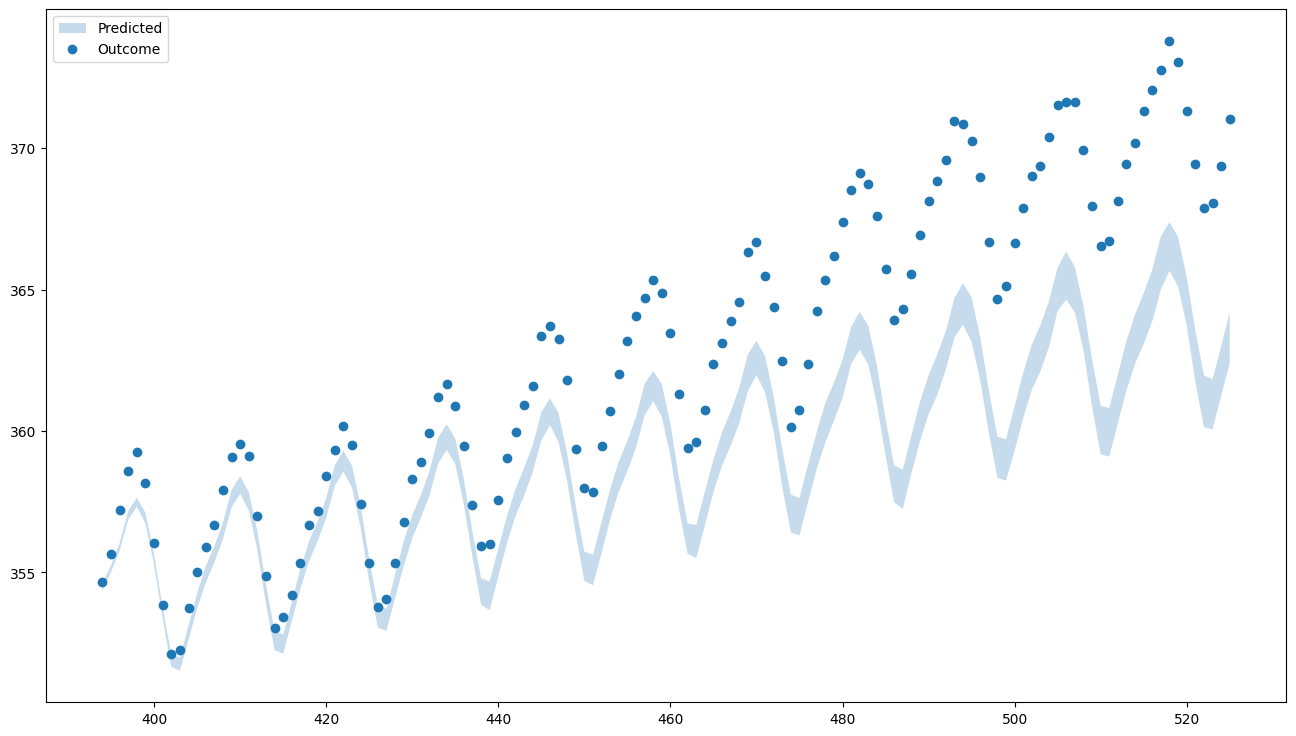

In [32]:
import numpy as np

low, high = np.quantile(predictions["y_future"], [0.025, 0.0975], axis=0)

x = np.arange(train.shape[0], test.shape[0] + train.shape[0])

fig, ax = plt.subplots()

ax.fill_between(x, low, high, alpha=0.25, label="Predicted")
ax.plot(x, test, "o", label="Outcome")

ax.legend()